In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [4]:
using Zygote, Lux, ComponentArrays, Plots, QuadGK, Interpolations, Optimisers, NNlib, PhasorNetworks
using Random: Xoshiro
using MLUtils: DataLoader

# Load the dataset

In [5]:
include("pixel_data.jl")

interpolate_roc (generic function with 1 method)

In [6]:
using Base: @kwdef

In [7]:
@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 128    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
end

Args

In [8]:
args = Args(batchsize = 128)

Args(0.0003, 128, 10, false)

In [9]:
data_dir = "pixel_data/"

"pixel_data/"

In [10]:
file_pairs = get_dataset(data_dir)

10-element Vector{Tuple{String, String}}:
 ("pixel_data/labels/labels_d17301.parquet", "pixel_data/recon3D/recon3D_d17301.parquet")
 ("pixel_data/labels/labels_d17302.parquet", "pixel_data/recon3D/recon3D_d17302.parquet")
 ("pixel_data/labels/labels_d17303.parquet", "pixel_data/recon3D/recon3D_d17303.parquet")
 ("pixel_data/labels/labels_d17304.parquet", "pixel_data/recon3D/recon3D_d17304.parquet")
 ("pixel_data/labels/labels_d17305.parquet", "pixel_data/recon3D/recon3D_d17305.parquet")
 ("pixel_data/labels/labels_d17306.parquet", "pixel_data/recon3D/recon3D_d17306.parquet")
 ("pixel_data/labels/labels_d17307.parquet", "pixel_data/recon3D/recon3D_d17307.parquet")
 ("pixel_data/labels/labels_d17308.parquet", "pixel_data/recon3D/recon3D_d17308.parquet")
 ("pixel_data/labels/labels_d17309.parquet", "pixel_data/recon3D/recon3D_d17309.parquet")
 ("pixel_data/labels/labels_d17310.parquet", "pixel_data/recon3D/recon3D_d17310.parquet")

In [12]:
q, ylocal, pt = get_samples(file_pairs[1:2])

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [13]:
q_test, ylocal_test, pt_test = get_samples(file_pairs[3:3]);

In [14]:
q |> size

(20, 13, 21, 99991)

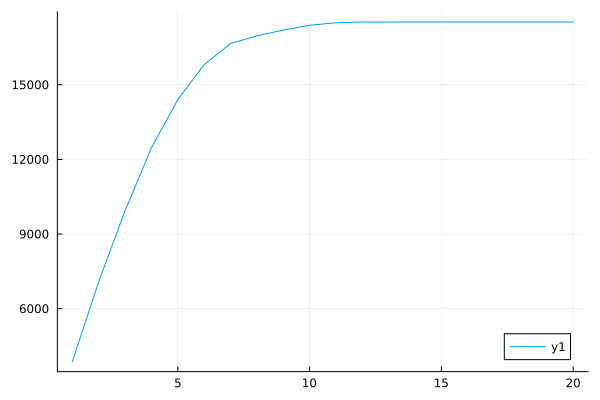

In [15]:
plot(sum(q[:,:,:,128], dims=(2,3)) |> vec)

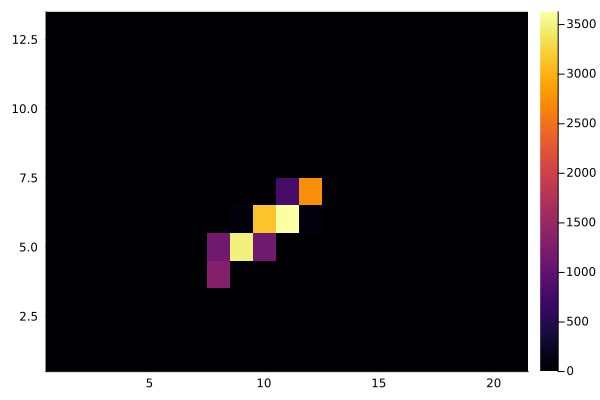

In [17]:
heatmap(q[12,:,:,128])

In [18]:
ylocal |> size

(99991,)

In [19]:
pt |> size

(99991,)

In [20]:
train_loader = DataLoader((q, ylocal, pt), batchsize=args.batchsize)

782-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [21]:
test_loader = DataLoader((q_test, ylocal_test, pt_test), batchsize=args.batchsize)

391-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [22]:
x, xl, y = first(train_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [23]:
x |> size

(20, 13, 21, 128)

In [24]:
n_px = size(x, 2)
n_in = n_px + 1

14

# Set up the model

In [25]:
function process_inputs(x, y_local)
    x = scale_charge(x[end,:,:,:])
    x = sum(x, dims=(2))
    n_batch = size(x, 3)
    x = reshape(x, (n_px, n_batch))
    y_local = reshape(y_local, (1, n_batch))

    x = cat(x, y_local, dims = 1)
    return x
end

process_inputs (generic function with 1 method)

In [26]:
process_inputs(x, xl)

14×128 Matrix{Float64}:
  0.0       0.0       0.0       0.0      …  0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.252     0.0004    0.0         0.0      0.03       0.0
  0.3008    1.4032    0.3624    0.6752      0.0      2.9176     0.5328
  0.8116    1.6196    0.89      2.6088      0.0      4.998      2.304
  1.0256    1.5404    1.2096    2.2608   …  1.1748   2.0668     2.768
  0.9528    0.6404    1.2876    3.8688      2.752    0.0        1.4048
  0.6928    0.0       0.464     0.0         0.0132   0.0        0.0
  0.4444    0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0      …  0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
 -6.94104  -4.33669  -7.79379  -2.67448     3.28174  0.134332  -1.43261

In [27]:
model = Chain(
    BatchNorm(n_in),
    x -> tanh.(x),
    Dense(n_in => 128, relu),
    Dense(128 => 3) 
)

Chain(
    layer_1 = BatchNorm(14, affine=true, track_stats=true),  # 28 parameters, plus 29
    layer_2 = WrappedFunction{:direct_call}(var"#73#74"()),
    layer_3 = Dense(14 => 128, relu),   # 1_920 parameters
    layer_4 = Dense(128 => 3),          # 387 parameters
)         # Total: 2_335 parameters,
          #        plus 29 states.

In [28]:
rng = Xoshiro(42)
ps, st = Lux.setup(rng, model)

((layer_1 = (scale = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.018712677 0.1624646 … 0.007739915 -0.16842416; -0.13419782 0.1107008 … 0.11776306 -0.17111422; … ; 0.14632118 -0.18586333 … -0.14887094 -0.09080278; 0.081494965 -0.12686923 … 0.11615222 -0.1931912], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;]), layer_4 = (weight = Float32[0.13702868 0.101796284 … -0.05596938 0.085558705; -0.0332754 -0.17838912 … 0.06668846 0.05473953; 0.076739706 -0.17085312 … -0.16301952 0.21299712], bias = Float32[0.0; 0.0; 0.0;;])), (layer_1 = (running_mean = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], running_var = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [29]:
y_naive, _ = model(process_inputs(x, xl), ps, st)

([-0.019485063948108172 -0.136781697891804 … -0.16637017674832433 -0.0593095332337971; 0.05314308407957796 0.011065292524927852 … 0.023149049119715544 0.02836798856406295; 0.028634477058718393 0.13628008960190938 … 0.045461147803512125 0.1126536342576662], (layer_1 = (running_mean = [0.0, 0.0007275000108405948, 0.009984687648783437, 0.06526031347245444, 0.18840875280750918, 0.2391881285641809, 0.20015500298254196, 0.05920625088224188, 0.008364062624634244, 0.0, 0.0, 0.0, 0.0, 0.07180550185123537], running_var = [0.8999999761581421, 0.9006013163245831, 0.9166694592716942, 1.0714547488537651, 1.6086467878359128, 1.8480822565809447, 1.6426738276027972, 1.0505631442442278, 0.9130537317768708, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 2.9173396135808085], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [30]:
y_naive |> size

(3, 128)

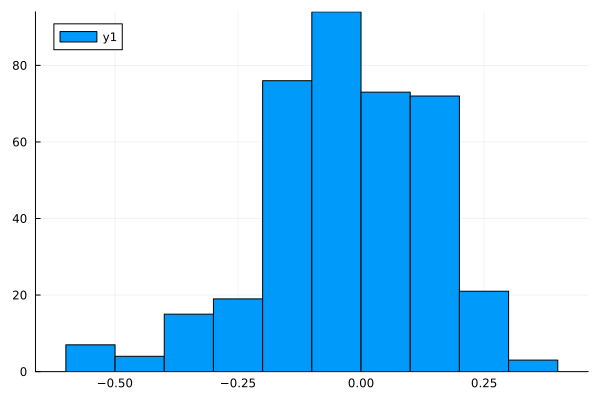

In [31]:
histogram(y_naive |> vec)

In [32]:
using Statistics: std, median, mean

In [33]:
using OneHotArrays

In [34]:
function get_truth(pt, threshold::Real = 0.2)
    return 1 .* (pt .> threshold) .+ 2 .* (pt .< -threshold)
end

get_truth (generic function with 2 methods)

In [35]:
function momentum_to_label(pt, threshold::Real = 0.2)
    y = onehotbatch(get_truth(pt, threshold), (0, 1, 2))
    return y
end

momentum_to_label (generic function with 2 methods)

In [36]:
labels = momentum_to_label(pt)

3×99991 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  1  ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1
 1  1  ⋅  1  1  ⋅  1  1  ⋅  ⋅  1  1  ⋅     1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  ⋅
 ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  1  1  ⋅  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  1  1  1  1  ⋅  ⋅  ⋅

In [37]:
logitcrossentropy(y_pred, y) = mean(-1 * sum(y .* logsoftmax(y_pred); dims=1))

logitcrossentropy (generic function with 1 method)

In [38]:
function loss(x, xl, y, model, ps, st, threshold)
    y_pred, st = model(process_inputs(x, xl), ps, st)
    y = momentum_to_label(y, threshold)
    loss = logitcrossentropy(y_pred, y)
    return loss, st
end

loss (generic function with 1 method)

In [39]:
@time loss(x, xl, y, model, ps, st, 0.2)

  0.371157 seconds (1.11 M allocations: 75.141 MiB, 3.31% gc time, 99.88% compilation time)


(1.0700868376182622, (layer_1 = (running_mean = [0.0, 0.0007275000108405948, 0.009984687648783437, 0.06526031347245444, 0.18840875280750918, 0.2391881285641809, 0.20015500298254196, 0.05920625088224188, 0.008364062624634244, 0.0, 0.0, 0.0, 0.0, 0.07180550185123537], running_var = [0.8999999761581421, 0.9006013163245831, 0.9166694592716942, 1.0714547488537651, 1.6086467878359128, 1.8480822565809447, 1.6426738276027972, 1.0505631442442278, 0.9130537317768708, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 2.9173396135808085], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [40]:
function train(model, ps, st, train_loader, threshold::Real = 0.2; kws...)
    args = Args(; kws...) ## Collect options in a struct for convenience

    device = cpu

    @info "Constructing model and starting training"
    ## Construct model
    #model = build_model() |> device

    ## Optimizer
    opt_state = Optimisers.setup(Adam(3e-4), ps)
    losses = []

    ## Training
    for epoch in 1:args.epochs
        epoch_losses = []
        for (x, xl, y) in train_loader
            (loss_val, st), gs = withgradient(p -> loss(x, xl, y, model, p, st, threshold), ps)
            append!(epoch_losses, loss_val)
            opt_state, ps = Optimisers.update(opt_state, ps, gs[1]) ## update parameters
        end
        append!(losses, mean(epoch_losses))
    end

    return losses, ps, st
end

train (generic function with 2 methods)

In [41]:
@time loss_history, pst, stt = train(model, ps, st, train_loader, 0.2, epochs = 10)

[ Info: Constructing model and starting training


 40.254700 seconds (58.51 M allocations: 101.605 GiB, 16.01% gc time, 47.63% compilation time)


(Any[0.8597558078062496, 0.8169873029068191, 0.8015839799054236, 0.7900564161632401, 0.7810977685988882, 0.7738851924560622, 0.7679508855544297, 0.7630572394436349, 0.758983680278727, 0.755527056965735], (layer_1 = (scale = Float32[0.87692815, 1.121983, 1.2268131, 1.2821653, 1.1830407, 1.103699, 1.1784396, 1.2597182, 1.084194, 0.8671646, 0.8702138, 1.0362478, 0.77769953, 0.7570058], bias = Float32[-0.18914413, -0.033993386, 0.09141249, 0.2476566, 0.24529845, 0.28544518, 0.1932294, 0.1522768, 0.097991854, -0.003997102, -0.17995651, -0.015670089, -0.19064184, 0.158464]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[9.222344f-5 0.017491177 … 0.10057766 -0.23768856; -0.16889559 0.25356933 … 0.09060394 -0.10359076; … ; 0.05498073 -0.31026214 … -0.2104792 0.012851562; 0.09706174 -0.31856668 … 0.14316322 -0.38383767], bias = Float32[-0.20878403; -0.046908107; … ; 0.15612362; -0.050920967;;]), layer_4 = (weight = Float32[0.11242152 0.19747356 … -0.08529031 0.112577595; -0.30785236 -0.34

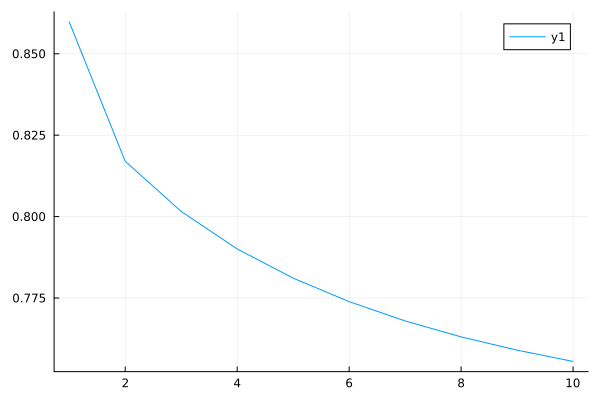

In [42]:
plot(loss_history)

In [43]:
#loss_history2, pst2, stt2 = train(model, pst, stt, train_loader, 0.2, epochs = 190)

In [44]:
#plot(vcat(loss_history, loss_history2))

In [45]:
#pst = pst2

In [46]:
sttf = Lux.testmode(stt)

(layer_1 = (running_mean = [0.03594616161788155, 0.04065939470148213, 0.24366647968169539, 1.0156471076493, 2.3585091340869972, 2.6301745158212135, 1.8952205505395425, 0.6306864595118056, 0.0972046012689178, 0.019270684388906934, 0.011654752692122225, 0.005198475128358864, 0.006348779794351645, 0.15291454619067543], running_var = [0.17845984020323682, 0.10809495006040458, 0.5665038009449749, 2.9413779193354155, 9.074032896510717, 7.835651333226607, 7.166495019956767, 1.96909766899202, 0.2683655759503202, 0.06505530708282091, 0.03435994576714579, 0.008197384732891742, 0.03335087394257168, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple())

In [47]:
loss(x, xl, y, model, pst, sttf, 0.2)

(0.6599128726904308, (layer_1 = (running_mean = [0.03594616161788155, 0.04065939470148213, 0.24366647968169539, 1.0156471076493, 2.3585091340869972, 2.6301745158212135, 1.8952205505395425, 0.6306864595118056, 0.0972046012689178, 0.019270684388906934, 0.011654752692122225, 0.005198475128358864, 0.006348779794351645, 0.15291454619067543], running_var = [0.17845984020323682, 0.10809495006040458, 0.5665038009449749, 2.9413779193354155, 9.074032896510717, 7.835651333226607, 7.166495019956767, 1.96909766899202, 0.2683655759503202, 0.06505530708282091, 0.03435994576714579, 0.008197384732891742, 0.03335087394257168, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [48]:
yt, _ = model(process_inputs(x, xl), pst, stt)

([-1.3405100739434002 -1.423071924540419 … -1.0716607765752337 -1.0326154862975288; 1.6588942359348349 0.556296574041202 … 0.5641144305899666 0.5420178088712263; -0.1429415237163428 1.416865234183719 … 1.7014079571644825 0.951068829679816], (layer_1 = (running_mean = [0.032351544599070116, 0.037320954272779004, 0.2292845135528477, 0.9793426861419106, 2.3110669172545673, 2.606345130095026, 1.905853453282551, 0.6268240494061299, 0.09584820144912198, 0.017343615490567323, 0.010489277145039045, 0.0046786274915816715, 0.0057139016635497746, 0.20942858977707637], running_var = [0.160613851928099, 0.09788679264362067, 0.5265228904575264, 2.8186948299695826, 8.875276202195613, 8.000168293510264, 7.19251919854319, 1.9227510232319571, 0.25458276757568293, 0.058549774823499434, 0.030923950371226264, 0.007377646064161686, 0.030015785753167712, 19.978280087850898], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

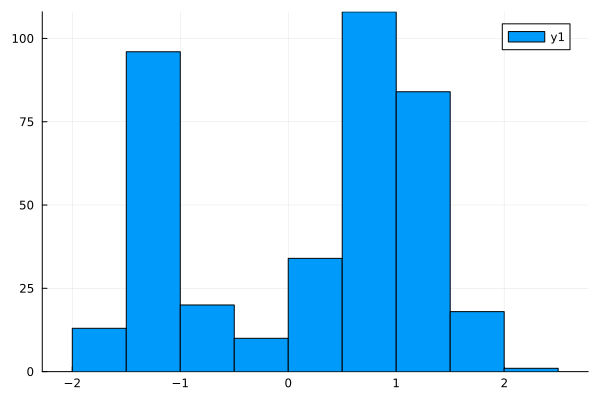

In [49]:
histogram(yt |> vec)

# Calculate the Test Loss

In [50]:
xts, xlts, yts = first(test_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [51]:
function accuracy(x, xl, y, model, ps, st, threshold::Real)
    y_truth = get_truth(y, threshold)
    y_pred, _ = model(process_inputs(x, xl), ps, st)
    y_labels = onecold(y_pred, (0, 1, 2))
    right = sum(y_truth .== y_labels)
    return right
end

accuracy (generic function with 1 method)

In [52]:
yth, _ = model(process_inputs(xts, xlts), pst, sttf)

([-1.2689367507340097 -1.0968660446812988 … -1.0125350807634876 -0.9249232184025787; 0.034741000947181744 -0.016379090816920933 … 1.0097232979072843 1.2985244261147606; 1.7582693534899958 1.3612362569046106 … 0.3043094960489718 -0.0025242479534518386], (layer_1 = (running_mean = [0.03594616161788155, 0.04065939470148213, 0.24366647968169539, 1.0156471076493, 2.3585091340869972, 2.6301745158212135, 1.8952205505395425, 0.6306864595118056, 0.0972046012689178, 0.019270684388906934, 0.011654752692122225, 0.005198475128358864, 0.006348779794351645, 0.15291454619067543], running_var = [0.17845984020323682, 0.10809495006040458, 0.5665038009449749, 2.9413779193354155, 9.074032896510717, 7.835651333226607, 7.166495019956767, 1.96909766899202, 0.2683655759503202, 0.06505530708282091, 0.03435994576714579, 0.008197384732891742, 0.03335087394257168, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [53]:
accuracy(q_test[:,:,:,1:10000], ylocal_test[1:10000], pt_test[1:10000], model, pst, sttf, 0.2)

6862

In [54]:
using LinearAlgebra: diag

In [55]:
yth, _ = model(process_inputs(q_test[:,:,:,1:10000], ylocal_test[1:10000]), pst, sttf)

([-1.2689367507340097 -1.0968660446812988 … -1.5033702624538037 -1.2233902072096543; 0.034741000947181744 -0.016379090816920933 … 0.3493678043434669 1.095971393592238; 1.7582693534899958 1.3612362569046106 … 1.1547194479682896 1.0181035094695525], (layer_1 = (running_mean = [0.03594616161788155, 0.04065939470148213, 0.24366647968169539, 1.0156471076493, 2.3585091340869972, 2.6301745158212135, 1.8952205505395425, 0.6306864595118056, 0.0972046012689178, 0.019270684388906934, 0.011654752692122225, 0.005198475128358864, 0.006348779794351645, 0.15291454619067543], running_var = [0.17845984020323682, 0.10809495006040458, 0.5665038009449749, 2.9413779193354155, 9.074032896510717, 7.835651333226607, 7.166495019956767, 1.96909766899202, 0.2683655759503202, 0.06505530708282091, 0.03435994576714579, 0.008197384732891742, 0.03335087394257168, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [56]:
roc = tpr_fpr(yth, pt_test[1:10000])

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [57]:
roc_fn = interpolate_roc(roc)

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    203-element Vector{Float64}:
│     0.0
│     0.0
│     0.0
│     0.0
│     0.0
│     ⋮
│     1.0
│     1.0
│     1.0
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/91PhN/src/gridded/gridded.jl:77


203-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Throw()) with element type Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

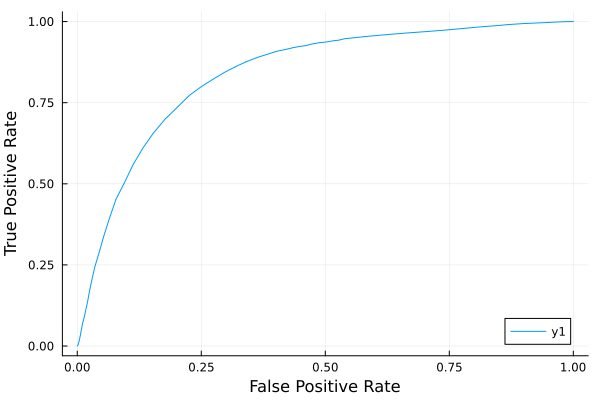

In [58]:
plot(roc[2], roc[1])
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

In [59]:
auc, _ = quadgk(roc_fn, 0.0, 1.0)

(0.8409609045922121, 1.21436372451233e-8)